In [54]:
import numpy as np
import pandas as pd
from glob import glob
from tqdm import tqdm
import seaborn as sns
import matplotlib.pyplot as plt
import PIL
import cv2
import os
from keras.utils import np_utils
from keras.preprocessing import image
from sklearn.datasets import load_files
from keras.layers import Conv2D, MaxPooling2D, Dense, Flatten
from sklearn.metrics import confusion_matrix
from keras.models import Sequential
from keras import optimizers

In [2]:
path_to_train_folder = os.path.join(os.path.pardir, "data", "train_images")
path_to_test_folder = os.path.join(os.path.pardir, "data", "test_images")
path_to_validation_folder = os.path.join(os.path.pardir, "data", "valid_images")

### Load dataset

In [3]:
#function to load data from given path
def load_dataset(path):
    data = load_files(path)
    doc_files = np.array(data['filenames'])
    doc_targets = np_utils.to_categorical(np.array(data['target']), 16)
    return doc_files, doc_targets

In [4]:
#Load data from filepaths
train_files, train_targets = load_dataset(path_to_train_folder)
valid_files, valid_targets = load_dataset(path_to_validation_folder)
test_files, test_targets = load_dataset(path_to_test_folder)

In [5]:
#check the dataset
print('There are %s total doc images.\n' % len(np.hstack([train_files, valid_files])))
print('There are %d training doc images.' % len(train_files))
print('There are %d validation doc images.' % len(valid_files))
print('There are %d test doc images.'% len(test_files))

There are 4800 total doc images.

There are 3200 training doc images.
There are 1600 validation doc images.
There are 1600 test doc images.


### Convert all images to 4D arrays

In [15]:
#function that converts image into 4D array to facilitate Keras CNN
def convert_4darray(img_path):
    # loads RGB image
    img = image.load_img(img_path, target_size=(224, 224))
    # convert PIL.Image.Image type to 3D tensor with shape (224, 224, 3)
    x = image.img_to_array(img)
    # convert 3D tensor to 4D tensor with shape (1, 224, 224, 3) and return 4D tensor
    return np.expand_dims(x, axis=0)

In [16]:
#fucntion which converts all images in given path to 4D array for Keras CNN
def convert_4darrays(img_paths):
    list_of_tensors = [convert_4darray(img_path) for img_path in tqdm(img_paths)]
    return np.vstack(list_of_tensors)

In [17]:
#pre-process the data for Keras
train_tensors = convert_4darrays(train_files).astype('float32')/255
test_tensors = convert_4darrays(test_files).astype('float32')/255
valid_tensors = convert_4darrays(valid_files).astype('float32')/255

100%|██████████| 1600/1600 [00:49<00:00, 32.39it/s]


## Convolutional Neural Network model

In [21]:
#Model CNN
model = Sequential()
# Conv layer 1
model.add(Conv2D(32, (7, 7), strides=(1, 1), use_bias=False, padding='same', activation='relu', input_shape=(224, 224, 3)))
# max pooling layer 1
model.add(MaxPooling2D(pool_size=(3, 3), strides=3))

# Conv layer 2
model.add(Conv2D(32, (5, 5), padding='same', activation='relu'))
# Mac pooling layer 2
model.add(MaxPooling2D(pool_size=(3, 3), strides=3))

# Conv layer 3
model.add(Conv2D(32, (3, 3), padding='same', activation='relu'))
# Max pooling layer 3
model.add(MaxPooling2D(pool_size=(3, 3), strides=3))

# Conv layer 4
model.add(Conv2D(32, (3, 3), padding='same', activation='relu'))

# Conv layer 5
model.add(Conv2D(32, (3, 3), padding='same', activation='relu'))
# Max pooling layer 4
model.add(MaxPooling2D(pool_size=(3, 3), strides=3))

# Flatten layer 
model.add(Flatten())
model.add(Dense(32, activation='relu'))
# Predictions
model.add(Dense(16, activation='softmax'))

# Model summary
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 224, 224, 32)      4704      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 74, 74, 32)        25632     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 24, 24, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 24, 24, 32)        9248      
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 8, 8, 32)          0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 8, 8, 32)         

In [33]:
EPOCHS = 10
from keras.callbacks import EarlyStopping
# Compile the model
model.compile(optimizer= 'adam', loss='mean_squared_error', metrics=['accuracy'])
# Fit the model
early_stopping = EarlyStopping(monitor='loss', patience=2)
fit_model = model.fit(train_tensors, train_targets, validation_data=(valid_tensors, valid_targets), epochs=EPOCHS, batch_size=64, verbose=1, callbacks=[early_stopping])
# Get index of predicted document for each image in test set
predictions = [np.argmax(model.predict(np.expand_dims(tensor, axis=0))) for tensor in test_tensors]

Train on 3200 samples, validate on 1600 samples
Epoch 1/10
3200/3200 [==============================] - ETA: 2:37 - loss: 0.0449 - accuracy: 0.39 - ETA: 2:14 - loss: 0.0427 - accuracy: 0.46 - ETA: 2:03 - loss: 0.0430 - accuracy: 0.46 - ETA: 1:56 - loss: 0.0422 - accuracy: 0.48 - ETA: 1:51 - loss: 0.0412 - accuracy: 0.50 - ETA: 1:46 - loss: 0.0420 - accuracy: 0.47 - ETA: 1:42 - loss: 0.0410 - accuracy: 0.49 - ETA: 1:39 - loss: 0.0410 - accuracy: 0.49 - ETA: 1:35 - loss: 0.0407 - accuracy: 0.49 - ETA: 1:32 - loss: 0.0407 - accuracy: 0.50 - ETA: 1:31 - loss: 0.0406 - accuracy: 0.50 - ETA: 1:28 - loss: 0.0405 - accuracy: 0.50 - ETA: 1:25 - loss: 0.0403 - accuracy: 0.50 - ETA: 1:24 - loss: 0.0405 - accuracy: 0.50 - ETA: 1:23 - loss: 0.0407 - accuracy: 0.49 - ETA: 1:23 - loss: 0.0404 - accuracy: 0.50 - ETA: 1:23 - loss: 0.0402 - accuracy: 0.50 - ETA: 1:23 - loss: 0.0403 - accuracy: 0.50 - ETA: 1:22 - loss: 0.0402 - accuracy: 0.50 - ETA: 1:20 - loss: 0.0406 - accuracy: 0.49 - ETA: 1:18 - loss

3200/3200 [==============================] - ETA: 1:47 - loss: 0.0314 - accuracy: 0.59 - ETA: 1:46 - loss: 0.0305 - accuracy: 0.63 - ETA: 1:43 - loss: 0.0328 - accuracy: 0.61 - ETA: 1:41 - loss: 0.0329 - accuracy: 0.61 - ETA: 1:38 - loss: 0.0324 - accuracy: 0.61 - ETA: 1:35 - loss: 0.0321 - accuracy: 0.61 - ETA: 1:33 - loss: 0.0313 - accuracy: 0.62 - ETA: 1:30 - loss: 0.0309 - accuracy: 0.62 - ETA: 1:28 - loss: 0.0312 - accuracy: 0.62 - ETA: 1:26 - loss: 0.0313 - accuracy: 0.62 - ETA: 1:25 - loss: 0.0307 - accuracy: 0.62 - ETA: 1:24 - loss: 0.0305 - accuracy: 0.63 - ETA: 1:22 - loss: 0.0309 - accuracy: 0.62 - ETA: 1:19 - loss: 0.0304 - accuracy: 0.63 - ETA: 1:17 - loss: 0.0306 - accuracy: 0.63 - ETA: 1:15 - loss: 0.0309 - accuracy: 0.63 - ETA: 1:13 - loss: 0.0308 - accuracy: 0.63 - ETA: 1:10 - loss: 0.0311 - accuracy: 0.62 - ETA: 1:08 - loss: 0.0307 - accuracy: 0.63 - ETA: 1:06 - loss: 0.0305 - accuracy: 0.63 - ETA: 1:03 - loss: 0.0304 - accuracy: 0.63 - ETA: 1:01 - loss: 0.0306 - accu

In [63]:
# Test accuracy
test_accuracy = 100*np.sum(np.array(predictions)==np.argmax(test_targets, axis=1))/len(predictions)
print('Test accuracy: %.4f%%' % test_accuracy)

Test accuracy: 46.2500%


### Accuracy and loss variation for test and train datasets

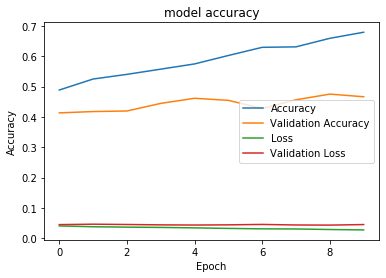

In [70]:
plt.plot(fit_model.history["accuracy"])
plt.plot(fit_model.history['val_accuracy'])
plt.plot(fit_model.history['loss'])
plt.plot(fit_model.history['val_loss'])
plt.title("model accuracy")
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.legend(["Accuracy","Validation Accuracy","Loss","Validation Loss"])
plt.show()

## Confusion Matrix

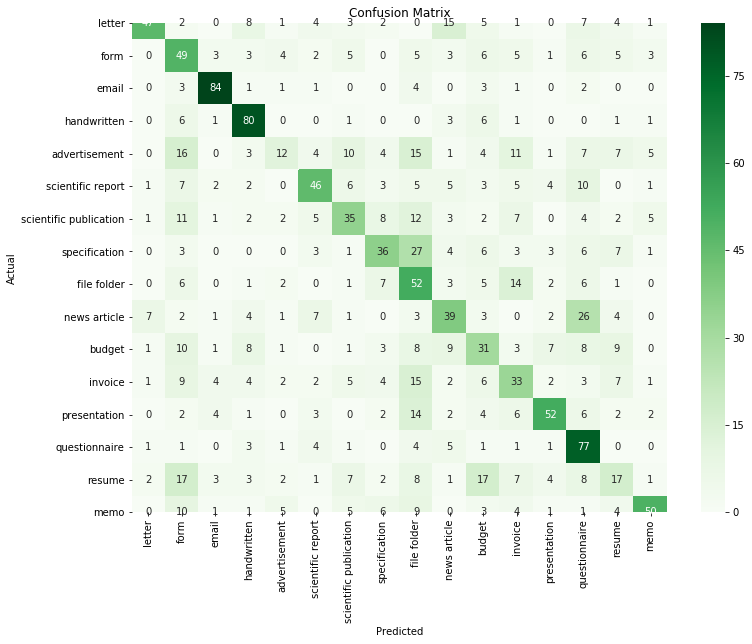

In [65]:
rounded_labels=np.argmax(test_targets, axis=1)
cm = confusion_matrix(rounded_labels, predictions)

classes = {'letter': '0', 'form': '1', 'email': '2', 'handwritten': '3', 'advertisement': '4', 'scientific report': '5',
           'scientific publication': '6', 'specification': '7', 'file folder': '8', 'news article': '9', 'budget': '10',
           'invoice': '11', 'presentation': '12', 'questionnaire': '13', 'resume': '14', 'memo': '15'}

df_cm = pd.DataFrame(cm, index = classes.keys(), columns = classes.keys())
plt.figure(figsize = (12,9))
sns.heatmap(df_cm, annot=True, fmt='g', cmap='Greens')
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()